# Relax structures with M3GNet

In this notebook, the CIFs are parsed with the parser built and creates a pymatgen structure object. 
The M3GNet graph neural network with 3-body interactions is loaded and used to relax all cells.

This is performed as follows:

- First, a full relaxation (cell and atomic positions) with LBFGS is performed, with a convergence threshold (fmax) of $10^{-1}$ (unspecificied units since it is based on forces and stress tensor elements).
- Secondly, a relaxation of only the atomic positions is performed with the FIRE optimiser and a tighter convergence thresold of $10^{-2}$.

The results of the relaxations are saved in the form of xyz files that contain the structures along the relaxation path. Plots showing the change in energy relative to the final relaxed energy are given as a function of the relaxation step.

In [1]:
#import the packages used

from __future__ import annotations

import warnings

from pymatgen.core import Lattice, Structure
from pymatgen.io.ase import AseAtomsAdaptor

import matgl
from matgl.ext.ase import M3GNetCalculator, MolecularDynamics, Relaxer
import parser
import matplotlib.pyplot as plt
import os
import time
from ase import Atoms
from ase.io import write

In [2]:
# Function that creates a pymatgen Structure object, following the parsing of the 
# CIF file and extraction of the important information (lattice parameters, species and atomic positions).

def create_struc(filename):
    s = parser.CIFParser(filename)
    a,b,c,alpha,beta,gamma = s.lattice_parameters[:]
    lattice = Lattice.from_parameters(a,b,c,alpha,beta,gamma)
    atomic_positions = []
    elements = []
    for key in s.unique_positions:
        for i in range(len(s.unique_positions[key])):
            elements.append(key)
            atomic_positions.append(s.unique_positions[key][i])
    return Structure(lattice, elements, atomic_positions, coords_are_cartesian=False)

In [3]:
# Loading of the M3GNet model.
pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")

In [4]:
# Find all the CIF files in the database.
directory_path = os.path.join("CIF")
cif_files = [os.path.join(directory_path,file) for file in os.listdir(directory_path) if file.endswith(".cif")]

In [5]:
# Perform the two step relaxation

# Store the relaxation results
d_results = {}

for filename in cif_files:

    name = filename.split('/')[1].split('.')[0]

    # Name of the CIF file
    print(name)

    # Load structure
    structure = create_struc(filename)

    t = time.time()
    # First relaxation calculatorm using M3GNet and LBFGS
    relaxer = Relaxer(potential=pot,optimizer="LBFGS")
    relax_results_full = relaxer.relax(structure, fmax=0.1)
    print(len(relax_results_full["trajectory"]))
    print(time.time() - t)
    
    # Store first result of the relaxation.
    d_results[name] = [relax_results_full]

    t = time.time()
    # Second relaxation calculator (only atomic positions) using M3GNet and FIRE
    relaxer = Relaxer(potential=pot,optimizer="FIRE",relax_cell=False)
    relax_results_pos = relaxer.relax(relax_results_full["final_structure"], fmax=0.01,steps=1000)
    print(len(relax_results_pos["trajectory"]))
    print(time.time() - t)
    
    d_results[name].append(relax_results_pos)

group-18_CollCode194747
162
125.1048653125763
12
7.743098497390747
group-14-4_CollCode14593
502
402.67192912101746
786
521.8181731700897
group-14-4_CollCode22693
22
2.985736131668091
26
0.8244874477386475
group-16_CollCode15910
136
18.218825817108154
53
1.3041415214538574
group-16_CollCode9868_mod
31
5.791536092758179
10
0.84794020652771
group-16_CollCode240086_mod
398
82.33820700645447
318
30.512394666671753
group-14-4_CollCode5301_mod
12
1.6411383152008057
28
1.1833081245422363
group-16_CollCode80164
238
36.35532736778259
15
0.6386408805847168
group-18_CollCode39248
318
70.7154266834259
55
6.342279672622681
group-16_CollCode88766
300
48.43381690979004
98
5.34434962272644
group-18_CollCode64937_mod
60
15.832324743270874
85
13.733591556549072
group-18_CollCode64939
233
34.262871503829956
22
0.8369896411895752
group-16_CollCode240084_mod
220
36.898587703704834
88
4.93329381942749
group-14-4_CollCode21535
54
12.99631404876709
9
1.213294267654419
group-18_CollCode163980
33
4.8262398242950

In [6]:
# Write the output results

for key in d_results:

    # Store structures and species from the information from the relaxation path.
    structures = []
    species = [specie.specie.symbol for specie in d_results[key][0]["final_structure"].sites]

    # Information from the first relaxation.
    for i in range(len(d_results[key][0]['trajectory'])):
        lattice = Lattice(d_results[key][0]['trajectory'][i][-2])
        structures.append(Structure(lattice,species,d_results[key][0]['trajectory'][i][-1],coords_are_cartesian=True).to_ase_atoms())
    
    # Information from the second relaxation.
    for i in range(len(d_results[key][1]['trajectory'])):
        lattice = Lattice(d_results[key][1]['trajectory'][i][-2])
        structures.append(Structure(lattice,species,d_results[key][1]['trajectory'][i][-1],coords_are_cartesian=True).to_ase_atoms())

    # Define the output file name
    output_file = os.path.join("Relaxations",f"{key}.extxyz")

    # Write the Atoms object to the .extxyz file
    write(output_file, structures, format="extxyz")

    print(f"Written {len(structures)} atoms to {output_file}")

Written 174 atoms to Relaxations/group-18_CollCode194747.extxyz
Written 1288 atoms to Relaxations/group-14-4_CollCode14593.extxyz
Written 48 atoms to Relaxations/group-14-4_CollCode22693.extxyz
Written 189 atoms to Relaxations/group-16_CollCode15910.extxyz
Written 41 atoms to Relaxations/group-16_CollCode9868_mod.extxyz
Written 716 atoms to Relaxations/group-16_CollCode240086_mod.extxyz
Written 40 atoms to Relaxations/group-14-4_CollCode5301_mod.extxyz
Written 253 atoms to Relaxations/group-16_CollCode80164.extxyz
Written 373 atoms to Relaxations/group-18_CollCode39248.extxyz
Written 398 atoms to Relaxations/group-16_CollCode88766.extxyz
Written 145 atoms to Relaxations/group-18_CollCode64937_mod.extxyz
Written 255 atoms to Relaxations/group-18_CollCode64939.extxyz
Written 308 atoms to Relaxations/group-16_CollCode240084_mod.extxyz
Written 63 atoms to Relaxations/group-14-4_CollCode21535.extxyz
Written 52 atoms to Relaxations/group-18_CollCode163980.extxyz
Written 61 atoms to Relaxatio

group-18_CollCode194747
group-14-4_CollCode14593
group-14-4_CollCode22693
group-16_CollCode15910
group-16_CollCode9868_mod
group-16_CollCode240086_mod
group-14-4_CollCode5301_mod
group-16_CollCode80164
group-18_CollCode39248
group-16_CollCode88766
group-18_CollCode64937_mod
group-18_CollCode64939
group-16_CollCode240084_mod
group-14-4_CollCode21535
group-18_CollCode163980
group-14-2_CollCode13560
group-18_CollCode244749
group-18_CollCode60570


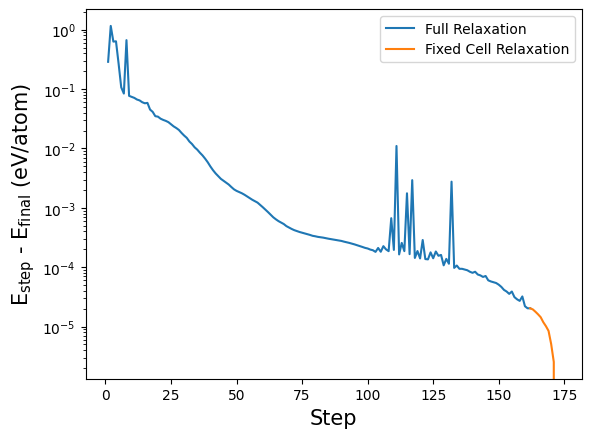

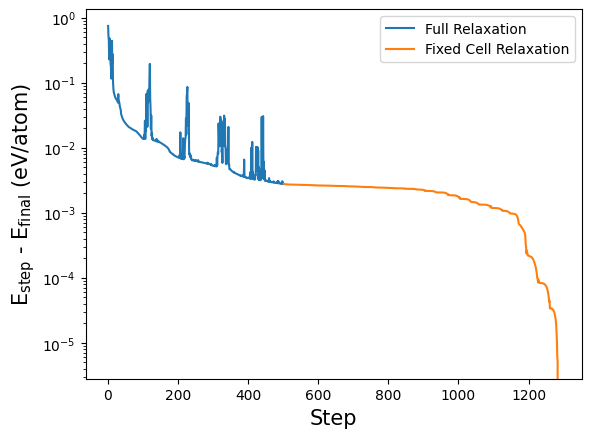

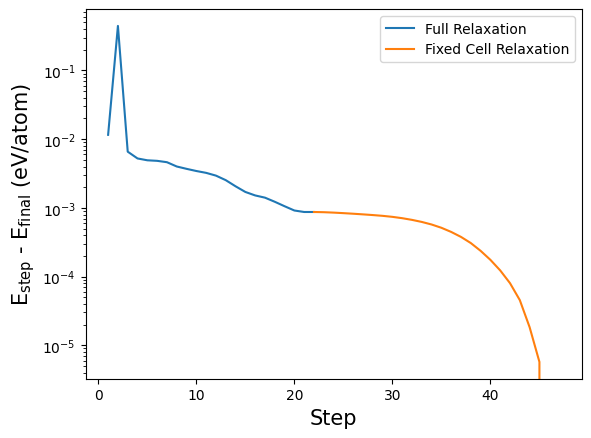

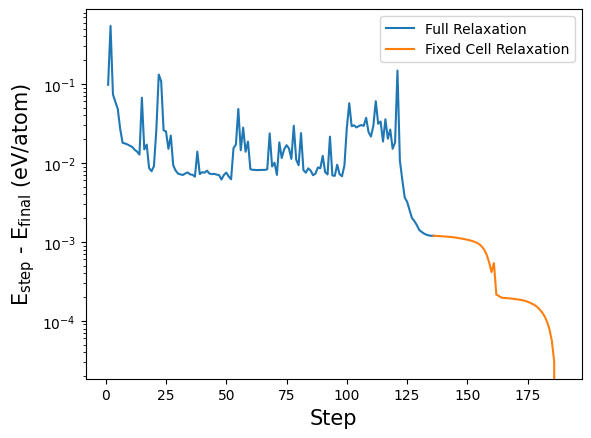

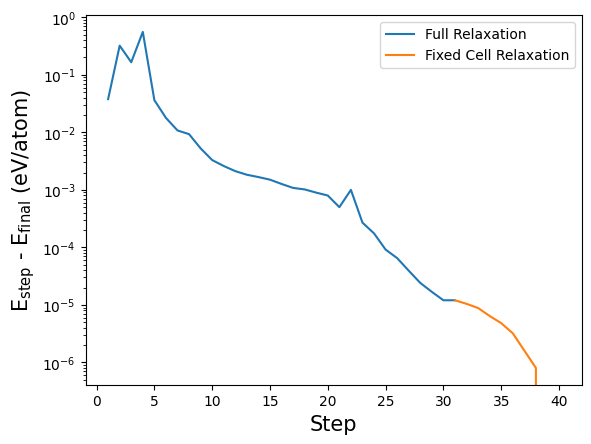

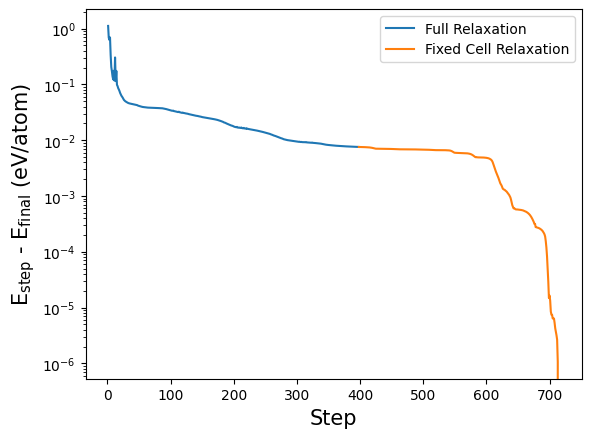

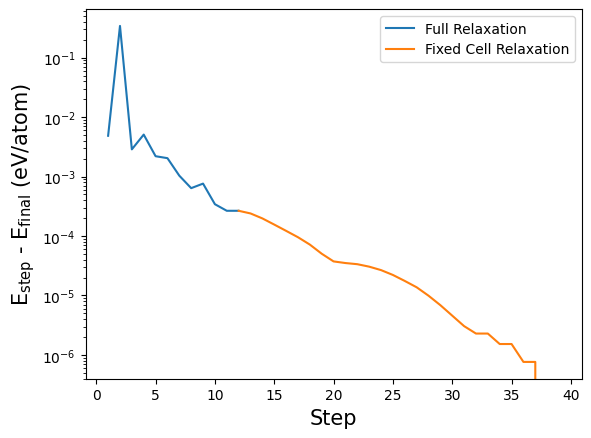

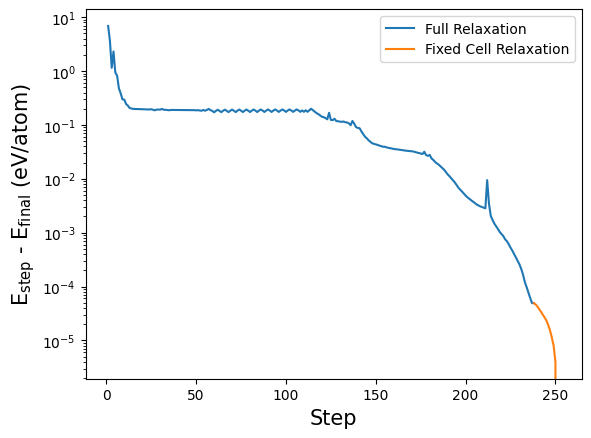

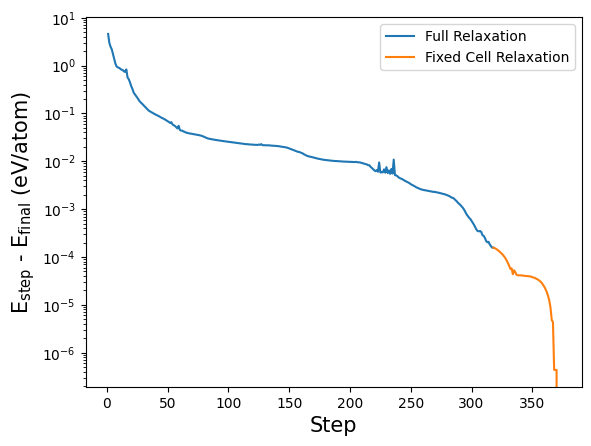

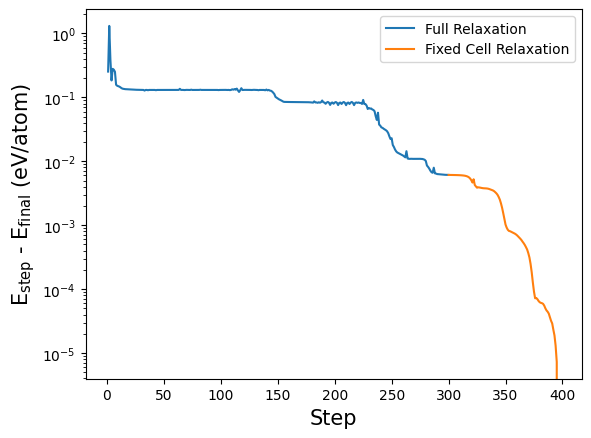

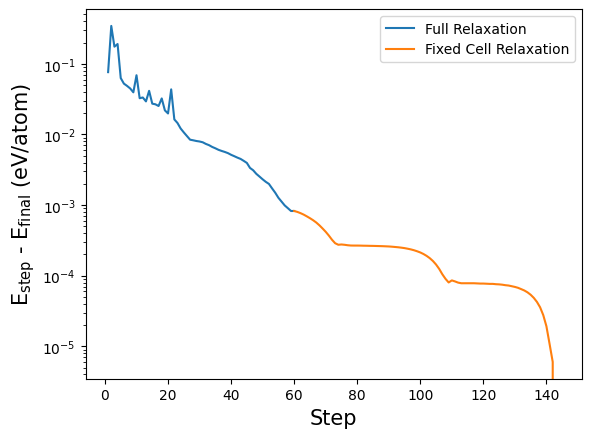

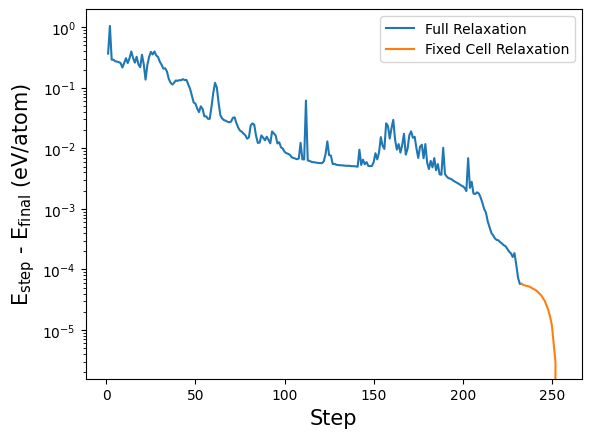

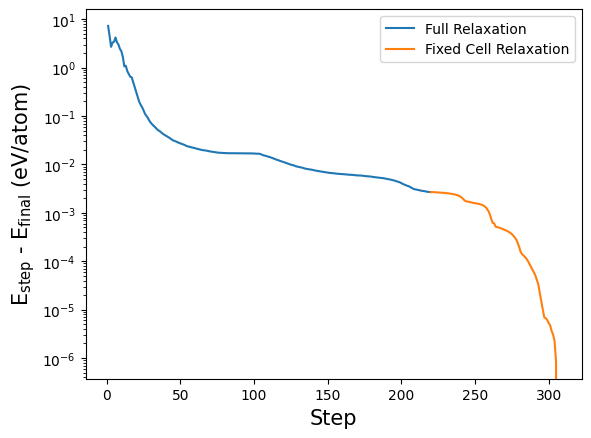

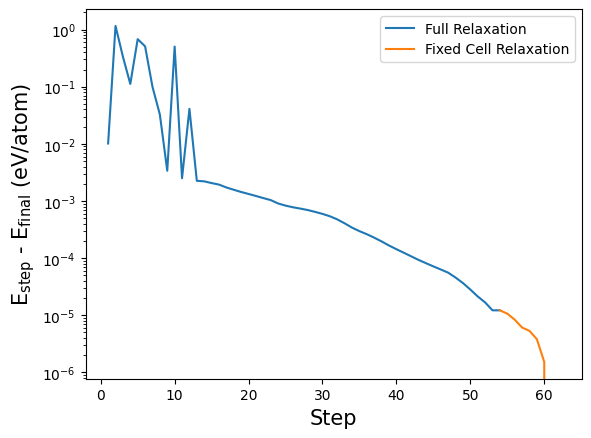

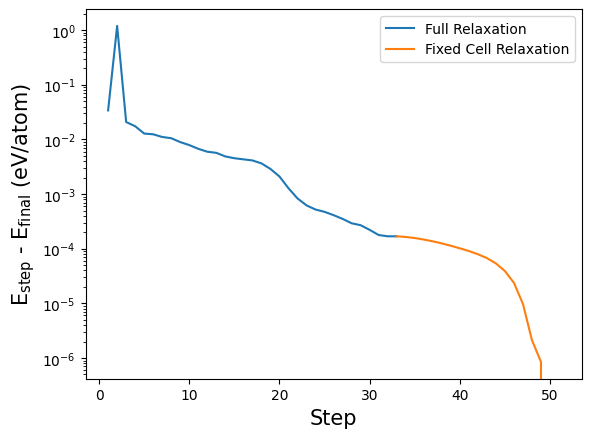

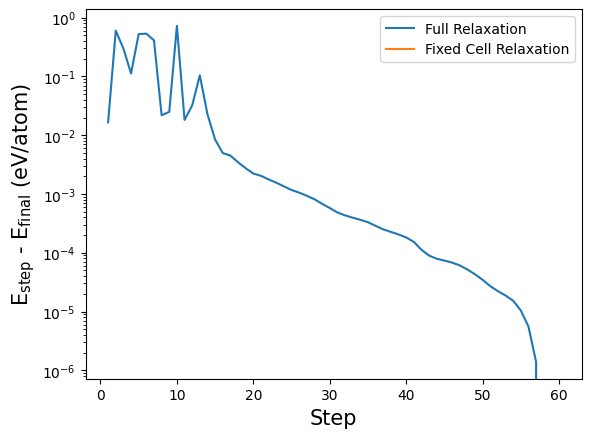

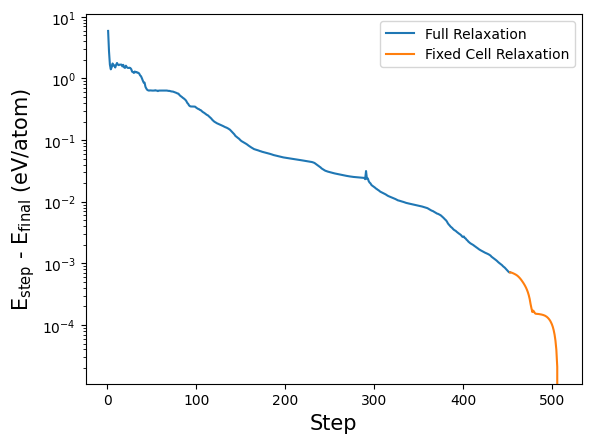

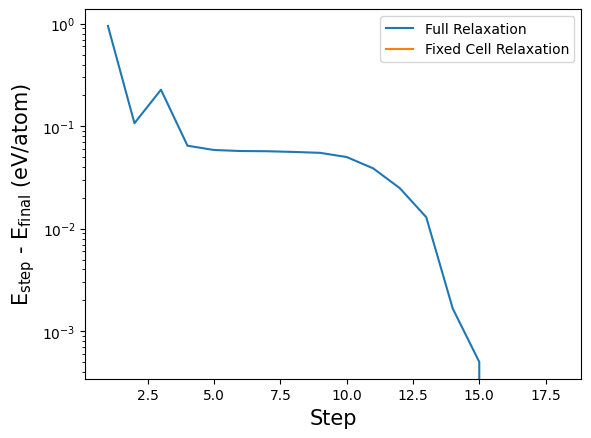

In [7]:
# Create the images of the energy change during the relaxations.

for key in d_results:
    
    #Number of atoms and the final energy.
    Na = len(d_results[key][1]['final_structure'])
    Ef = d_results[key][1]["trajectory"].energies[-1]/Na
    
    # Store results of the steps and the energies during the first relaxation.
    n_full = len(d_results[key][0]['trajectory'])
    E_full = []
    step_full = [i+1 for i in range(n_full)]
    
    for i in range(n_full):
        E_full.append((d_results[key][0]['trajectory'][i][0]/Na)-Ef)
    
    # Store results of the steps and the energies during the second relaxation.
    n_atom = len(d_results[key][1]['trajectory'])
    E_atom = []
    step_atom = [i+len(step_full) for i in range(n_atom)]
    
    for i in range(n_atom):
        E_atom.append((d_results[key][1]['trajectory'][i][0]/Na)-Ef)
    
    print(key)
    
    
    # Plot the results.
    plt.figure()
    
    plt.yscale("log")
    plt.plot(step_full,E_full,label="Full Relaxation")
    plt.plot(step_atom,E_atom,label="Fixed Cell Relaxation")
    
    plt.xlabel("Step",size=15)
    plt.ylabel("E$_\mathrm{step}$ - E$_\mathrm{final}$ (eV/atom)",size=15)
    
    plt.legend()
    
    plt.savefig(os.path.join("Relaxations",f"{key}_rel.pdf"))
    #plt.show()